In [83]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
    using Random
    using Statistics
    using DiffEqCallbacks
    using Test
    using ChainRulesCore
    using LineSearches
end 

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


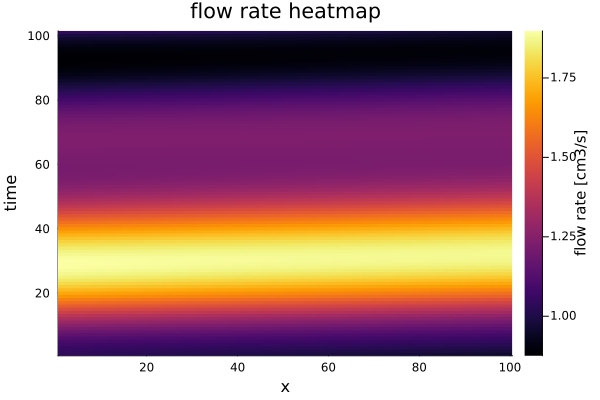

In [4]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];

heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


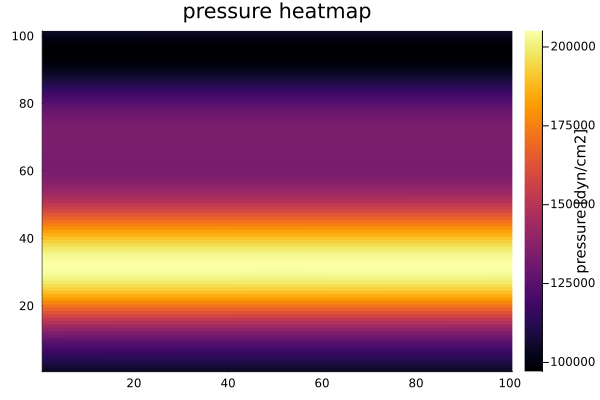

In [5]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [6]:
begin
    global dt = 0.001                     # time step, has to be smaller or equal to saveat
    global T = 1.0                   # total time
    global saveat = 0.01                #ground truth data time resolution
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem
    global L = 4.0                       # total length of 1d sim
    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.01         # learning rate , currently using PolyOpt default (0.1)


end

0.01

In [10]:
#waveforms to use
waveforms = 30


# Set the seed for reproducibility
Random.seed!(1234)

# Shuffle the indices of the vector
shuffled_indices = randperm(size(data1d_fix)[3])

# Divide the shuffled indices into training and test sets
train_indices = shuffled_indices[1:waveforms];
test_indices = shuffled_indices[waveforms+1:end];

# # Shuffle the indices of the vector
# shuffled_indices = 1:47

# # Divide the shuffled indices into training and test sets
# train_indices = shuffled_indices[18:end];
# test_indices = shuffled_indices[1:17];

# select field variable ID
# 1 - flow rate, 2 - pressure, 3 - area, 4 - Wall Shear Stress
pID = 1

1

In [11]:
#define IC's
u0 = data1d_fix[1,1:end,train_indices,pID];
u01 = data1d_fix[1,1:end,1,pID];

u0_test = data1d_fix[1,1:end,test_indices,pID];

In [12]:
#ground truth data
ytrain2 = data1d_fix[:,1:end,train_indices,pID];
ytrain21 = data1d_fix[:,1:end,1,pID];

ytest2 = data1d_fix[:,1:end,test_indices,pID];

#boundary conditions
bc_flow = data1d_fix[:,1,train_indices,pID];
bc_flow1 = bc_flow[:,1];

bc_flow_test = data1d_fix[:,1,test_indices,pID];

In [13]:
aID = 3
#ground truth data for area
Atrain = data1d_fix[:,1:end,train_indices,aID];
Atrain1 = data1d_fix[:,1:end,1,aID];

Atest = data1d_fix[:,1:end,test_indices,aID];

In [14]:
presID = 2
#ground truth data for pressure
ptrain = data1d_fix[:,1:end,train_indices,presID];
ptrain1 = data1d_fix[:,1:end,1,presID];

ptest = data1d_fix[:,1:end,test_indices,presID];

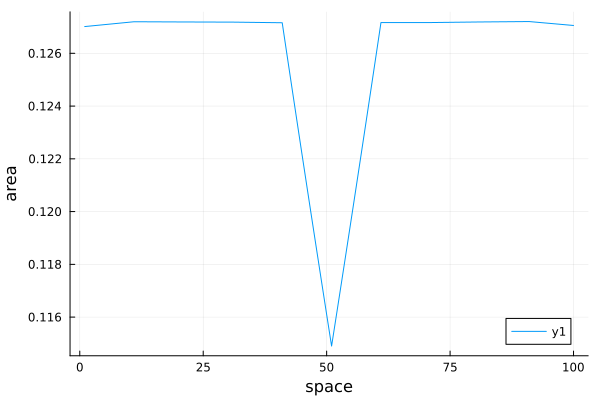

In [15]:
plot(Atrain1[1,:])
xlabel!("space")
ylabel!("area")

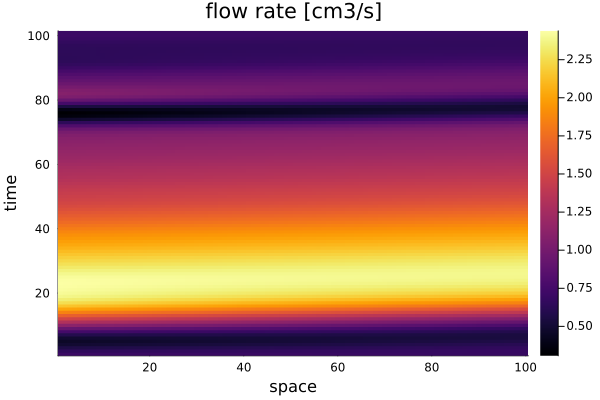

In [16]:
heatmap(ytrain2[:,:,1])
xlabel!("space")
ylabel!("time")
title!("flow rate [cm3/s]")

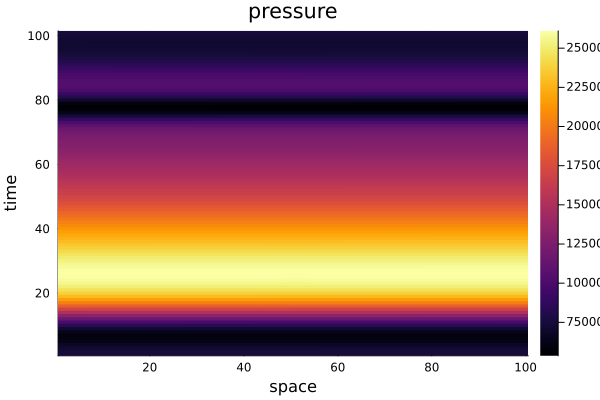

In [17]:
heatmap(ptrain[:,:,1])
xlabel!("space")
ylabel!("time")
title!("pressure")

In [84]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [79]:
N = size(u01,1)
dx = L/N                      # spatial step
x = 0.0 : dx : (L-dx)         # discretized spatial dimension 
# finite-difference schemes

#first order derivatives
∂x1_center = f1_secondOrder_central(N,dx);
∂x1_forward = f1_secondOrder_forward(N,dx);
∂x1_backward = f1_secondOrder_backward(N,dx);

# use central difference for the majority
∂x1 = ∂x1_center
# use forward and backward difference near the boundaries
∂x1[1,:]=∂x1_forward[1,:]
∂x1[end,:] = ∂x1_backward[end,:]

#second order derivatives
∂x2_center = f2_secondOrder_central(N,dx);
∂x2_forward = f2_secondOrder_forward(N,dx);
∂x2_backward = f2_secondOrder_backward(N,dx);

# use central difference for the majority
∂x2 = ∂x2_center;
# use forward and backward difference near the boundaries
∂x2[1,:]=∂x2_forward[1,:];
∂x2[end,:] = ∂x2_backward[end,:];

In [53]:

# NN embedded in PDE for Differential programming
# Define the network architecture with initialization
hidden_dim = 10

ann = Chain(
    Dense(N, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, N, init = Flux.glorot_uniform)
)

Chain(
  Dense(100 => 10, tanh),               # 1_010 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 100),                     # 1_100 parameters
)                   # Total: 8 arrays, 2_330 parameters, 9.602 KiB.

In [54]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2330


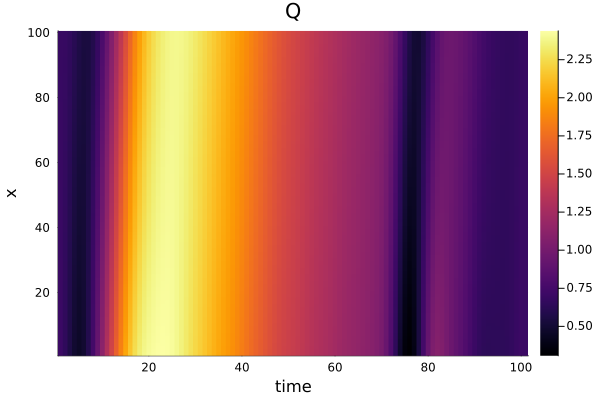

In [55]:
ytrain = permutedims(ytrain2[:,:,:],(2,3,1))

heatmap(ytrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("Q")

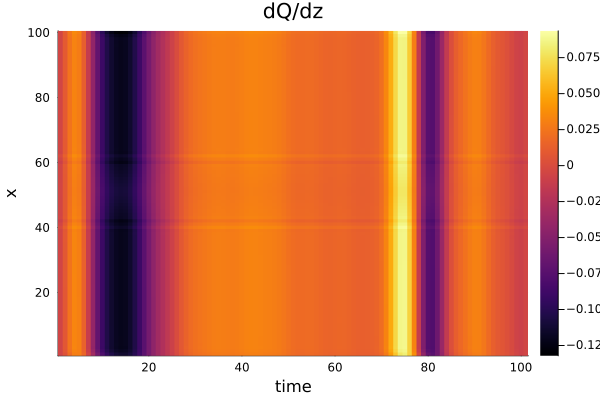

In [56]:
#plot derivatives for sanity check
heatmap(∂x1*ytrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("dQ/dz")

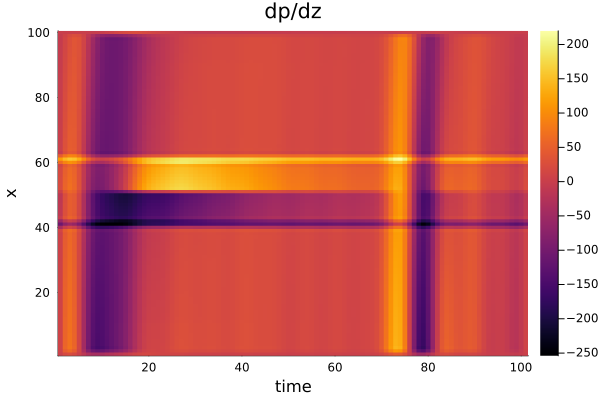

In [57]:
prestrain = permutedims(ptrain[:,:,:],(2,3,1))
heatmap(∂x1*prestrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("dp/dz")

In [58]:
δ = 1/3;  #profile parameters
ν = 0.04; # viscosity in CGS
ρ = 1.06; #density in CGS
Nprof = -8*π*ν;  #profile parameters

In [59]:
# # Define time-dependent variables
function interpolate_variables(t, vector)
    # t - dependent variable, could be time or space (z) too
    #      if t is time then use dt, if it's space use dz, same with T <--> L
    # vector - data vector with values at distinct t locations
    #
    # This function interpolates values such that we can access the values from vector
    # not just at the original data points but anywhere in between
    

    # Find the two closest points in vector
    #caculate the time index that's closest to time t

    t_index = Int(floor(t / saveat)) + 1

    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * saveat) / saveat

    # Perform linear interpolation between data points in vector
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    
    if t == T
        vector_interp = vector[:,:,t_index]
        
    else
        vector_interp = (1 - t_frac) * vector[:,:,t_index] + t_frac * vector[:,:,t_index + 1]
    end
    
    # return the interpolated value of vector at time(space) = t
    return vector_interp
end


# define interpolate function
interp_func(t) = interpolate_variables(t, atrain)

interp_func (generic function with 1 method)

In [60]:
function learn_1DBlood(u, p, t, interp_func, p_interp_func)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    
    # u - variable we are solving for
    # p - parameters
    # t - time
    #interp_func - interpolates area to the current t
    #p_interp_func - interpolates pressure to current t
    
    # omit the pressure term for now:  - interp_func(t) ./ ρ .* (∂x1 * p_interp_func(t)) 
    #- (1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t))) + Nprof .* u ./ interp_func(t) + ν .* (∂x2*u)
    
    
    # write out each term for debugging
#     if isapprox(t%0.1,0.0, atol = 1e-3)
#         println("time t: ", t)
#         println("advection term d/dz(Q^2/S): ", sum((1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t)))))
#         println("viscous resistance N*Q/S: ", sum(Nprof .* u ./ interp_func(t)))
#         println("Diffusion: nu*d^2Q/dz^2: ", sum(ν .* (∂x2*u)))
#         println("Mean area S: ", mean(interp_func(t)))
#         println("Mean Previous flow rate Q:", mean(u), ", std Q:", std(u))
#         println("Mean Q^2/S:", mean((u .* u) ./ interp_func(t)))
#         println("dp/dz term: ", sum(- interp_func(t) ./ ρ .* (∂x1 * p_interp_func(t))))
#         println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
#         flush(stdout)
#     end
    
#     plotQ = plot(u)
#     display(plot(plotQ))
#     sleep(1)
    
    #construct ODE
    return Φ(u) .- (1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t))) .+ Nprof .* u ./ interp_func(t) .+ ν .* (∂x2*u)
end

learn_1DBlood (generic function with 1 method)

In [61]:
# if RK4 - then uses the self-implemented RK4
# if Tsit5 - uses callback
# at the moment both crash :(
ode_solver = "RK4"
output_dir = "/home/tschala/research/LANL/some_physics_testNODE"
working_dir = output_dir

"/home/tschala/research/LANL/some_physics_testNODE"

In [62]:
# Runge-Kutta solver
function rk4_solve_1step(prob, θ, dt,tf,u0)
    # set initial condition
    u = u0
    
    # set problem right-hands side function
    f = prob.f
    
    # set initial time, one step before the final time
    ti = tf-dt
    
#     println("ti: ",ti)
    
    #calculate Runge-Kutta step
    k1 = f(u, θ, ti)
    k2 = f(u .+ dt/2 .* k1, θ, ti + dt/2)
    k3 = f(u .+ dt/2 .* k2, θ, ti + dt/2)
    k4 = f(u .+ dt .* k3, θ, ti + dt)

    u_new = u .+ dt/6 .* (k1 .+ 2*k2 .+ 2*k3 .+ k4)

    return u_new
end


rk4_solve_1step (generic function with 1 method)

In [63]:
function loss(θ, ytrain21, prob,bc_left)
    # solve system and calculate loss
    
    # θ - NN parameters
    # ytrain21 - ground truth data - shape: [space, batch, time]
    # prob - ODE problem formulation
    # bc_left - time-dependent BC 
    
    # list for saving results
    pred = []
    
    # initialize loss
    loss = 0.0
    
    # get the time span from the problem setup
    t0, tf = prob.tspan
    
    # get initial conditions
    u0 = prob.u0

    # save IC to list
    # MUST ignore gradients, otherwise mutation will occur
    # push creates mutation if derivatives are not ignored
    @ignore_derivatives push!(pred, u0)
    
    # calculate number of timesteps required
    num_steps = Int(round((tf - t0) / dt))
    
    # timestep loop
    for i in 1:num_steps
        
        # integrate one timestep at a time to avoid mutating arrays
        
        # set final time to 1 timestep ahead
        tf = dt*i
        
        # solve 1 time-step
        u_new = rk4_solve_1step(prob, θ, dt,tf,u0)
        

        
        # calculate the loss when time is the same as the ground truth
        # saveat is the time resolution of the ground truth data
        t_ratio = saveat/dt
        if isapprox(i % t_ratio, 0.0, atol=1e-6)
            # calculate index corresponding to time in the ground truth data
            index = Int(round(i /t_ratio))
            # cumulate the loss
            l = sum(abs2, u_new - ytrain21[:, :, index])
            loss += l
        end
        
        # apply inlet boundary condition
        bc_zeros = zeros(1,size(u0)[2])
        # create matrix which is 1 everywhere but 0 at the BC
        multiply = Float32.(vcat(bc_zeros,ones(size(u0)[1]-1,size(u0)[2])))
        
        # interpolate BC to current time step
        t_index = Int(floor(tf / saveat)) + 1

        # calculate local time fraction between the grid points
        t_frac = (tf - (t_index - 1) * saveat) / saveat

        # Perform linear interpolation between data points in vector
        # if we are at the last timesteps just copy the value cause t_index+1 will not exist
        if tf == T
            bc_interp = bc_left[t_index,:]
        else
            bc_interp = (1 - t_frac) * bc_left[t_index,:] + t_frac * bc_left[t_index + 1, :]
        end
        
        # create matrix that is zero everywhere except the BC, where it is the BC
        add = Float32.(vcat(reshape(bc_interp,1,size(bc_left)[2]),zeros(size(u0)[1]-1,size(u0)[2])))
        
        # set the new initial condition
        # use copy to avoid mutating arrays
        # apply BC by multiplying and adding, this is just a way to overcome mutation
        u0 = copy(u_new).*multiply.+add
        
        # save result to list, ignore gradients to avoid mutation
        if isapprox(i % t_ratio, 0.0, atol=1e-6)
            @ignore_derivatives push!(pred, u_new)
        end
        
    end
    
    #return the total loss at the end
    return loss, pred
end


# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob,bc_left),adtype) ;

In [64]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [65]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:RK4


In [66]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


Batch size:10
Start training epoch 1
waveform batch: 1/3
Using ADAM optimizer
Sum of params:723.86676
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 594.9069181846095
Iteration: 2 || Loss: 595.0932898983978
Iteration: 3 || Loss: 594.9638351526498
Iteration: 4 || Loss: 594.9718677876126
Iteration: 5 || Loss: 595.1315271928034
Iteration: 6 || Loss: 594.9069181846095
saving ADAM checkpoint...
Sum of params:723.86676
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 594.9069181846095
Iteration: 2 || Loss: 594.9058608732112
Iteration: 3 || Loss: 594.9058608732112
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:723.8661
Epoch 1 loss:594.9058608732112


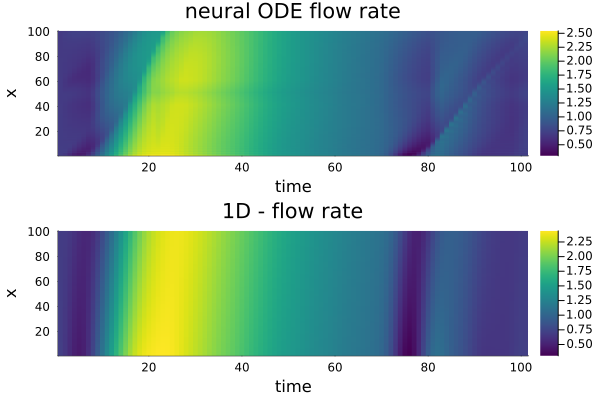

waveform batch: 2/3
Using ADAM optimizer
Sum of params:723.8661
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 215.20346923905393
Iteration: 2 || Loss: 215.06759656940764
Iteration: 3 || Loss: 214.66829520262846
Iteration: 4 || Loss: 214.56788966862607
Iteration: 5 || Loss: 214.24557510133255
Iteration: 6 || Loss: 214.24557510133255
saving ADAM checkpoint...
Sum of params:723.8773
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 214.24557510133255
Iteration: 2 || Loss: 214.06144361646614
Iteration: 3 || Loss: 213.82879396973536
Iteration: 4 || Loss: 213.06948468903886
Iteration: 5 || Loss: 199.42504108874544
Iteration: 6 || Loss: 194.26529517638562
Iteration: 7 || Loss: 186.82830894674797
Iteration: 8 || Loss: 186.250007650801
Iteration: 9 || Loss: 185.41133644671845
Iteration: 10 || Loss: 169.96444349067156
Iteration: 11 || Loss: 167.29173395995716
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:763.

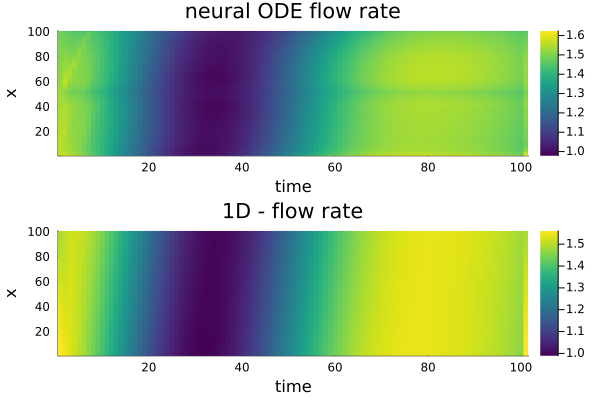

waveform batch: 3/3
Using ADAM optimizer
Sum of params:763.28064
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 119.18637747428194
Iteration: 2 || Loss: 118.96085834063447
Iteration: 3 || Loss: 118.80359804142971
Iteration: 4 || Loss: 118.71096903887494
Iteration: 5 || Loss: 118.67118335470822
Iteration: 6 || Loss: 118.67118335470822
saving ADAM checkpoint...
Sum of params:763.2068
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 118.67118335470822
Iteration: 2 || Loss: 118.66408054335096
Iteration: 3 || Loss: 117.81049609570904
Iteration: 4 || Loss: 108.99397869734361
Iteration: 5 || Loss: 104.78947805428388
Iteration: 6 || Loss: 103.75035945577623
Iteration: 7 || Loss: 103.37975036067455
Iteration: 8 || Loss: 102.43171548392293
Iteration: 9 || Loss: 101.48463026323914
Iteration: 10 || Loss: 100.91044784053419
Iteration: 11 || Loss: 99.8024251157961
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:771

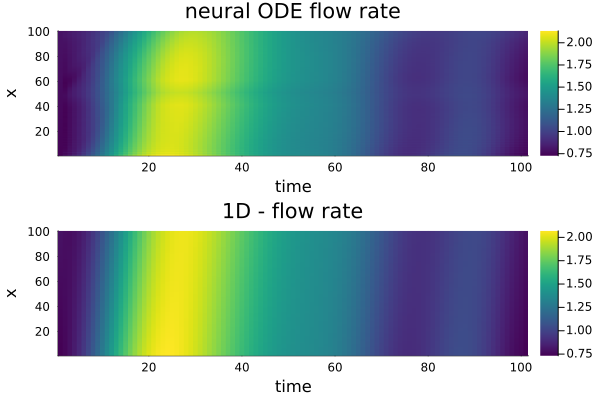

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/2
Test loss:161.62699905488844


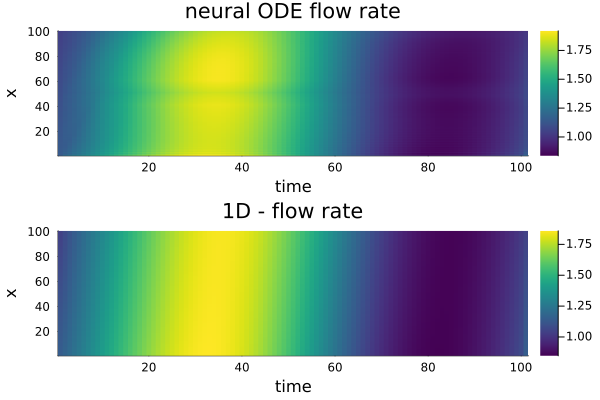

waveform batch: 2/2
Test loss:154.58689649667826


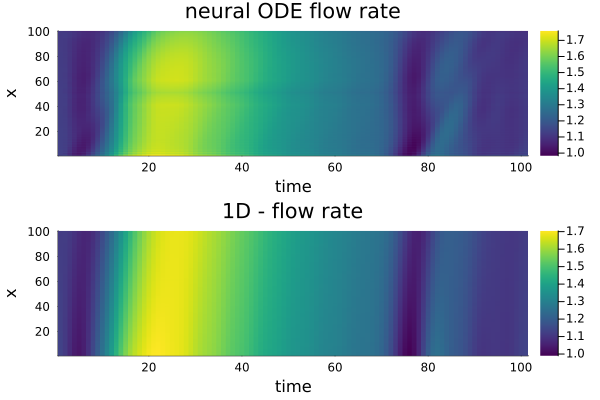

Epoch 1 mean train loss:28.73333399829881
Epoch 1 mean test loss:18.600817385386275
Start training epoch 2
waveform batch: 1/3
Using ADAM optimizer
Sum of params:771.8096
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 496.8390568437767
Iteration: 2 || Loss: 496.50525704326265
Iteration: 3 || Loss: 496.2126610594893
Iteration: 4 || Loss: 495.95920473082487
Iteration: 5 || Loss: 495.7399871056554
Iteration: 6 || Loss: 495.7399871056554
saving ADAM checkpoint...
Sum of params:771.8786
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 495.7399871056554
Iteration: 2 || Loss: 495.1453654051165
Iteration: 3 || Loss: 473.1513845913719
Iteration: 4 || Loss: 466.616428481307
Iteration: 5 || Loss: 461.249921446526
Iteration: 6 || Loss: 461.0903377072915
Iteration: 7 || Loss: 461.0903377072915
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:774.37714
Epoch 2 loss:461.0903377072915


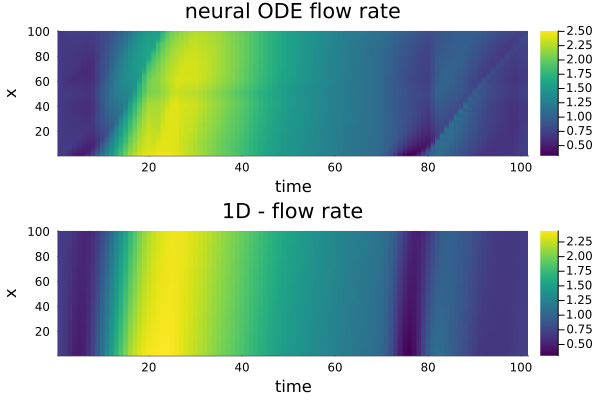

waveform batch: 2/3
Using ADAM optimizer
Sum of params:774.37714
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 157.59777651517751
Iteration: 2 || Loss: 157.35252278778077
Iteration: 3 || Loss: 157.36267661018755
Iteration: 4 || Loss: 157.34784555195182
Iteration: 5 || Loss: 157.3553586415677
Iteration: 6 || Loss: 157.34784555195182
saving ADAM checkpoint...
Sum of params:774.3969
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 157.34784555195182
Iteration: 2 || Loss: 157.34784555195182
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:774.3969
Epoch 2 loss:157.34784555195182


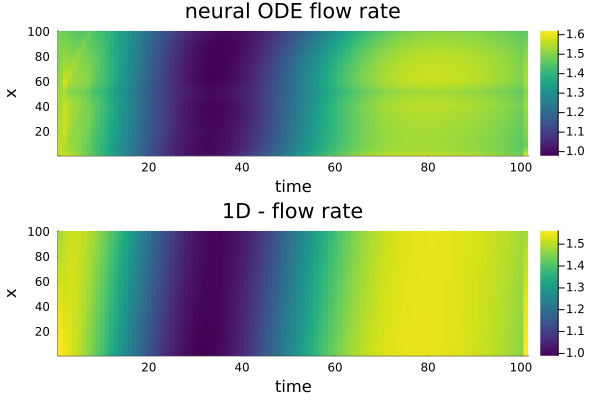

waveform batch: 3/3
Using ADAM optimizer
Sum of params:774.3969
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 106.22519877676898
Iteration: 2 || Loss: 106.23443106281174
Iteration: 3 || Loss: 106.2516158498523
Iteration: 4 || Loss: 106.2476503057915
Iteration: 5 || Loss: 106.25214213423949
Iteration: 6 || Loss: 106.22519877676898
saving ADAM checkpoint...
Sum of params:774.3969
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 106.22519877676898
Iteration: 2 || Loss: 106.22519877676898
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:774.3969
Epoch 2 loss:106.22519877676898


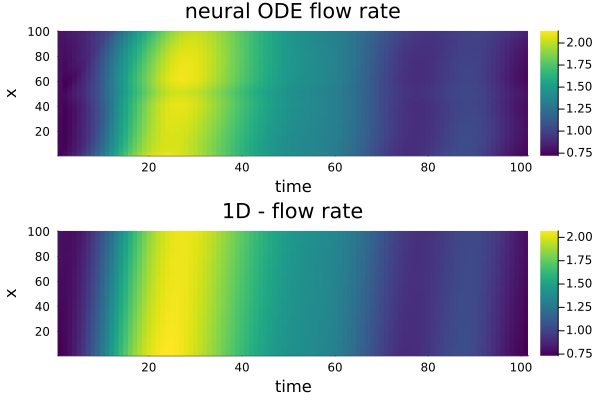

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing:
waveform batch: 1/2
Test loss:166.94841829663886


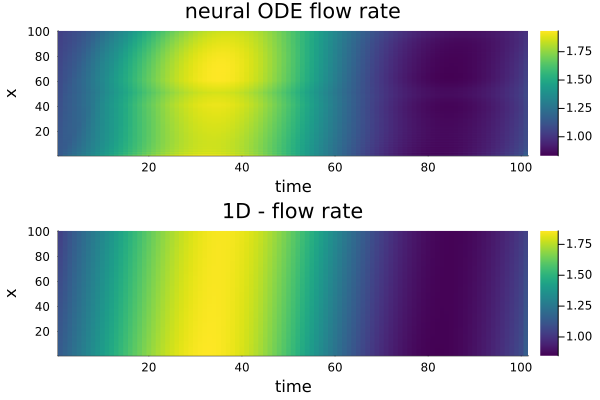

waveform batch: 2/2
Test loss:145.5817676861007


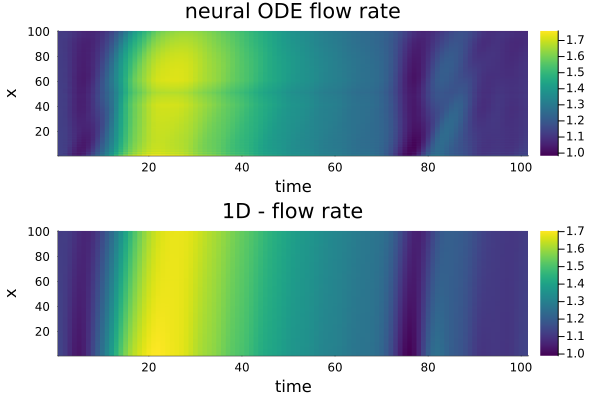

Epoch 2 mean train loss:24.15544606786707
Epoch 2 mean test loss:18.384128587219976
Start training epoch 3
waveform batch: 1/3
Using ADAM optimizer
Sum of params:774.3969
Changing learning rate to:1.0e-5
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 461.1772391335285
Iteration: 2 || Loss: 461.1876449712534
Iteration: 3 || Loss: 461.1823051211667
Iteration: 4 || Loss: 461.1628839591004
Iteration: 5 || Loss: 461.1339707748896
Iteration: 6 || Loss: 461.1339707748896
saving ADAM checkpoint...
Sum of params:774.4031
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 461.1339707748896
Iteration: 2 || Loss: 461.1339707748896
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:774.4031
Epoch 3 loss:461.1339707748896


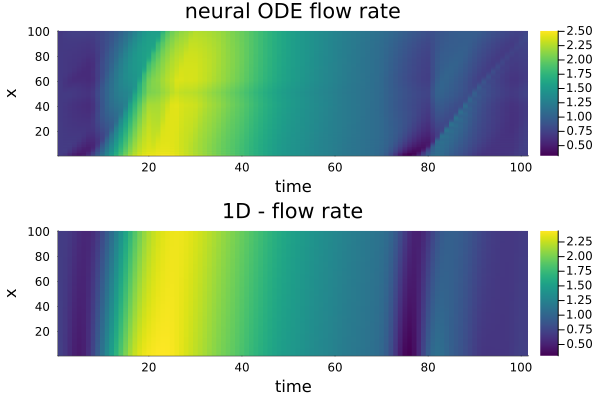

waveform batch: 2/3
Using ADAM optimizer
Sum of params:774.4031
Changing learning rate to:1.0000000000000002e-6
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 157.42686674024125
Iteration: 2 || Loss: 157.4040955140271
Iteration: 3 || Loss: 157.42728912026615
Iteration: 4 || Loss: 157.4046089670487
Iteration: 5 || Loss: 157.41737286763927
Iteration: 6 || Loss: 157.4040955140271
saving ADAM checkpoint...
Sum of params:774.40295
Switching to BFGS optimizer
Max iters:10
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 157.4040955140271
Iteration: 2 || Loss: 157.4040955140271
saving BFGS checkpoint...
saved trained params to ptrained_BFGS.jld2
Sum of params:774.40295
Epoch 3 loss:157.4040955140271


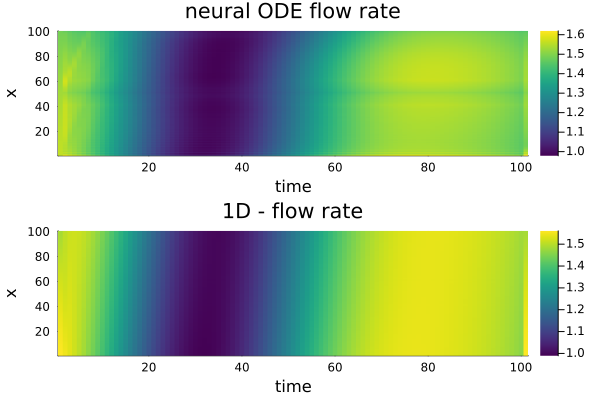

waveform batch: 3/3
Using ADAM optimizer
Sum of params:774.40295
Changing learning rate to:1.0000000000000002e-7
Max iters:5
Choosing ADAM Optimizer.


LoadError: InterruptException:

In [85]:
n_epochs = 100

#set batch size
batch_size = 10
println("Batch size:", batch_size)
#training batches
batch_iterations = Int(size(ytrain2,3)/batch_size)
#testing batches
test_batch_iterations = Int(ceil(size(ytest2,3)/batch_size));

list_loss_train = []
list_loss_epoch = []
list_loss_test = []
list_loss_epoch_test = []
# epochs loop
learning_rate = 0.01
for j in 1:n_epochs
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test = 0.0

        # loop over different waveforms
        for i in 1:batch_iterations

            println("waveform batch: ",i, "/",batch_iterations)



            flush(stdout)
            #reorder ytrain, atrain and dAdz to [space, batch_size, time]
            # batch size should be second column
            ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
            atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
        
            #define boundary condition for the current batch
            bctrain = bc_flow[:,batch_size*(i-1)+1:batch_size*i]
        
            #reorder pressure values as well
            prestrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))


            #define function for interpolating area to the actual time location for the ODE
            interp_func(t) = interpolate_variables(t, atrain)
            p_interp_func(t) = interpolate_variables(t, prestrain)
            
        
            #define optimization problem
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func, p_interp_func), ytrain[:,:,1], tspan, p);
            
            optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain[:,:,:],prob, bctrain),adtype) ;

            println("Using $optimizer_choice1 optimizer")
            println("Sum of params:", sum(uinit))

            # Change learning rate for ADAM optimizer, BFGS doesn't use it
            if j % 3 == 0
                global learning_rate = learning_rate*0.1
                println("Changing learning rate to:",learning_rate)
            end
            global uninit
            uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
            println("Sum of params:", sum(uinit))

            if !isnothing(optimizer_choice2)
                println("Switching to $optimizer_choice2 optimizer")

                uinit = train_loop(uinit,adtype,optf,train_maxiters*2,learning_rate,optimizer_choice2)

                println("Sum of params:", sum(uinit))

            end
        
            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func,p_interp_func), ytrain[:,:,1], tspan, p);
            l, pred = loss(uinit,ytrain[:,:,:],prob,bctrain)
            loss_tot = loss_tot + l

            push!(list_loss_train, l)
            println("Epoch ", j, " loss:", l)
        
        
            # Initialize the resulting matrix
            pred_matrix = zero(ytrain)

            # Restructure the matrices into the result matrix
            for i in 1:length(pred)
                pred_matrix[:, :, i] = pred[i]
            end

        
         
            # plot solution for comparison
            plot1 = heatmap(pred_matrix[:,1,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytrain[:,1,:], title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end
    
    
        #testing loop
        println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        println("Testing:")

        for i in 1:test_batch_iterations

            println("waveform batch: ",i, "/",test_batch_iterations)

            #reorder ytrain to (spatial location, batch_size, time)
            if i!=test_batch_iterations
                ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                atest = permutedims(Atest[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                bctest = bc_flow_test[:,batch_size*(i-1)+1:batch_size*i]
                prestest = permutedims(ptest[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
            else
                ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:end],(2,3,1))
                atest = permutedims(Atest[:,:,batch_size*(i-1)+1:end],(2,3,1))
                bctest = bc_flow_test[:,batch_size*(i-1)+1:end]
                prestest = permutedims(ptest[:,:,batch_size*(i-1)+1:end],(2,3,1))
            end
            

            #define function for interpolating area and dA/dz to the actual spatial location for the ODE
            interp_func(t) = interpolate_variables(t, atest)
            p_interp_func(t) = interpolate_variables(t, prestest)

            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func, p_interp_func), ytest[:,:,1], tspan, p);
            l, pred = loss(uinit,ytest[:,:,:],prob,bctest)
            loss_tot_test = loss_tot_test + l

            push!(list_loss_test, l)
            println("Test loss:",l )
        
            # Initialize the resulting matrix
            pred_matrix = zero(ytest)

            # Restructure the matrices into the result matrix
            for i in 1:length(pred)
                pred_matrix[:, :, i] = pred[i]
            end
        

            #plot solution for comparison
            plot1 = heatmap(pred_matrix[:,1,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytest[:,1,:], title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end


push!(list_loss_epoch, loss_tot/(size(ytrain2,3)))
push!(list_loss_epoch_test, loss_tot_test/(size(ytest2,3)))
println("Epoch ", j, " mean train loss:", loss_tot/(size(ytrain2,3)))
println("Epoch ", j, " mean test loss:", loss_tot_test/(size(ytest2,3)))
end


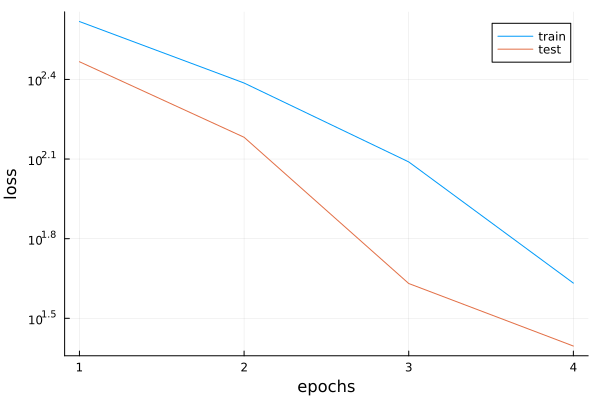

In [69]:
# plot loss as a function of epochs
p3 = plot([list_loss_epoch,list_loss_epoch_test], yaxis=:log, label = ["train" "test"])
ylabel!("loss")
xlabel!("epochs")
png("dQdt_1DBlood_loss.png")
display(p3)

### Load the final learnt parameters and do inference ###

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 5
# u01 = u0[:,wv]

# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 2
# u01 = u0[:,wv]

# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

### Step-by-step inference ###

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# nt = 10
# T = dt * nt  # total time
# tspan = (0.0, T)
# tsteps = 0:dt:tspan[2]  # create time vector  

In [ ]:
# sol_list = []
# for k in 2:11
#     println("t:",((k-2)*nt+1)*dt)
#     begin 
#         println(sum(u01))
#         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[k-1,wv]), u01[:,end], tspan, p)     # p changes after training   
# #         u01 = ytrain2[(k-2)*nt+1,:,wv]
# #         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[(k-2)*nt+1,wv]), u01, tspan, p)     # p changes after training   

            
#         if ode_solver == "Tsit5"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "RK4"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "Rosenbrock23"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         end
#         save_object(output_dir*"/sol_learn_paramBC_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#         println("saved trained solution")
#     end

#     sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_paramBC_testNODE_trained.jld2");
#     solution = sol_learn["single_stored_object"]
#     #overwrite initial condition by the solution
#     u01 = solution[:,2:end]
#     push!(sol_list,u01)
#     l = sum(abs2,u01-ytrain2[(k-2)*nt+1:(k-1)*nt,:,wv]')
#     println("Loss: ",l)
    
    
    
# # multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# # add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# # sol = solution.*multiply.+add
# end

# combined_sol = hcat(sol_list...);

# # sol = combined_sol[:,2:2:end];
# sol = combined_sol[:,:];

In [ ]:
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))